In [226]:
import pandas as pd
from sklearn import *
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
import numpy as np
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import f1_score as sk_f1_score
import matplotlib.pyplot as plt

чтение данных

In [227]:
df = pd.read_csv('feature_data_new_mini.csv', low_memory=False)
goal = pd.read_csv('goal_cipher.csv')

In [228]:
df.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


In [229]:
goal.head()

,Unnamed: 0,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
1,3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
2,4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
3,7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
4,9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


In [230]:
df[df.isnull().any(1)]

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
36451,145,1050.0,2.0,2021-08-28,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В данных присутствует строка со значением NaN, избавимся от нее, а также дубликатов

In [231]:
print(len(df), len(goal))
goal.drop_duplicates(inplace=True)
df.drop_duplicates(inplace=True)
df = df.dropna()
print(len(df), len(goal))

36452 53039
34888 53039


In [232]:
goal = goal[goal['fail_place'] == 'Гуайява обыкновенная']

len(goal)

1343

выбираем необходимые для обучения данные

In [233]:
goal = goal[['ser_loc','zns_loc','prs_loc','year_month', 'day']]
goal['day'] = goal['day'].astype(int)
df.head()

df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
goal['year_month'] = pd.to_datetime(goal['year_month'], format='%Y-%m')

df['year_month'] = df['year_month'].dt.to_period('M')
goal['year_month'] = goal['year_month'].dt.to_period('M')

df.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


объеденяем записи и удаляем не используемые столбцы 

In [234]:
df_main = goal.merge(df, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')

df_main = df_main.dropna(subset = ['count_fail'])

df_main = df_main.drop(columns=['date_repair_finish_y_1',
       'date_repair_finish_x_2',
       'date_repair_finish_y_2', 'date_repair_finish', 
       'date_repair_finish_x_1',])

In [235]:
df_main['day'] = [1 if x > 0 or None else 0 for x in df_main['day']]

df_main = df_main.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [236]:
df_main['day'].value_counts()

0    34859
1       33
Name: day, dtype: int64

Нормализация данных

In [237]:
scaler = preprocessing.MinMaxScaler()
d_scaler = scaler.fit_transform(df_main)
df_main = pd.DataFrame(d_scaler,columns = df_main.columns)

x = df_main.drop(columns=['day'])
y = df_main['day']

балансировка разделение данных на тренеровочную и тестовую

In [238]:

sm = SMOTE( k_neighbors=10, )
x_res, y_res = sm.fit_resample(x, y)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_res, y_res, test_size=0.1)

применение модели классификации 

In [239]:
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
)

In [240]:
clf.fit(x_train, y_train,         
        eval_set=(x, y), 
        verbose=False
)

строим матрицу ошибок на тестовой выборке

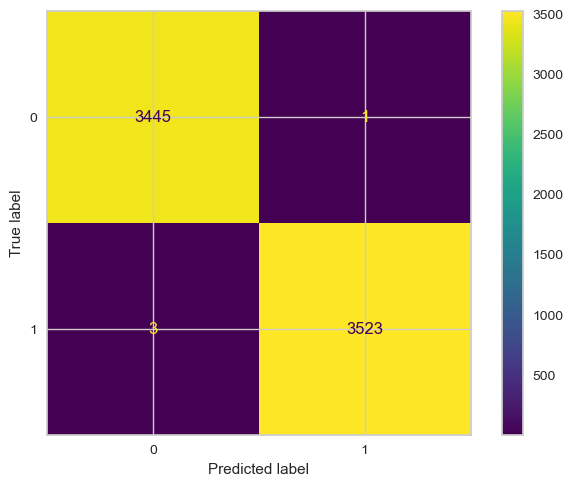

In [241]:
сonfus_m = confusion_matrix(y_test, clf.predict(x_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сonfus_m,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

строим матрицу ошибок на основной выборке

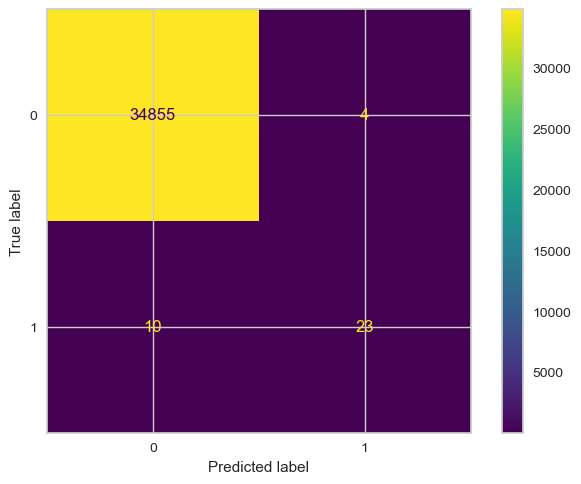

In [242]:
сonfus_m = confusion_matrix(y, clf.predict(x), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=сonfus_m,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

исходя из просмотра визуализаций можно предпроложить что точность предсказаний достаточно велико, оценим качество модели при помощи `f1_score`

используем собственную функцию

In [243]:
def f1_score(y , x , clf):
    tn, fp, fn, tp = confusion_matrix(y, clf.predict(x), labels=clf.classes_).ravel()
    precission = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precission * recall) / (precission + recall)

f1_score( y, x , clf)

0.7666666666666667

используем функцию из `sklearn.metrics`

In [244]:
from sklearn.metrics import f1_score as sk_f1_score
sk_f1_score(y, clf.predict(x))

0.7666666666666667